In [234]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

def SI(l, units):
    SI_I = (l * units).decompose()
    return SI_I.value

#Constants:
L = SI(5000, u.AA) #angstroms
T_test = 5730.97 #Kelvin
P_test = 1.2594 # = log(P)
T_test_vega = 6744.1
P_test_vega = -0.027889772
B = 0.1 #ratio of the #He/#H
A = 10**4 #ratio of #H/#metal
#sigma_t = SI(6.655*10**(-25), u.cm**2)#centimeter squared, used in thompson scattering 
sigma_t = 6.655*10**(-25) 
m_h = 1.6726219*10**(-24) #grams, mass of ionized hydrogen, eg. a proton
c = SI(29979245800, u.cm/u.s) #speed of light, centimeters per second
h = 6.62606896*10**(-27) #planck's constnat, erg * seconds
k = 1.38065*10**(-16) #boltzmann constant, ergs/Kelvin
Chi = 2.195*10**(-11) #ergs, ionization energy of hydrogen
x = 10000/L #substitution used in the absorption coefficients 
l = ((L*u.m).to(u.micron)).value #micrometers, wavelength of light, just converting L from angstroms to microns to clean up functions.
v = c/(L) #frequency associated with L

L_vega = SI(7000, u.AA)
l_vega = ((L_vega*u.m).to(u.micron)).value
v_vega = c/(L_vega)

#input data - sun-like star
check_ans = np.genfromtxt('opacities.dat', dtype='f8', names = ['temp', 'log_P', 'logH', 'logH-', 'logsigma'])
temp_pelog_dat = np.genfromtxt('temp_pelog.dat', dtype='f8', names = ['temp','log_P' ])
temp = check_ans['temp']
pe_log = check_ans['log_P']

#input data - vega
opacities_vega = np.genfromtxt('vega-atmos-grid.dat', dtype='f8', names = ['temp', 'P'])
temp_vega = opacities_vega['temp']
p_vega = opacities_vega['P']

In [235]:
#Defining theta
def Theta(T):
    theta = 5040./T
    return theta

#Defining the Saha equation for hydrogen. Returns the ratio of n/n
def Saha_H(T, P):
    Saha_H_ans =  (5.0/2.0)*np.log10(T) - 13.595*(Theta(T)) - P - 0.4772
    return 10**Saha_H_ans

#Defining the Saha equation for metals. Returns the ratio of n/n
def Saha_metals(T, P):
    Saha_metals_ans = (5.0/2.0)*np.log10(T) - 7.9*(Theta(T)) - P - 0.0971
    return 10**Saha_metals_ans

#Defining X = fraction of H ionized
def X(H_ratio):
    X_ans = H_ratio / (1 + H_ratio)
    return X_ans

#Defining Y = faction of metal ionized 
def Y(m_ratio):
    Y_ans = m_ratio / (1 + m_ratio)
    return Y_ans

#Sun
H_ratio = Saha_H(temp, pe_log)
m_ratio = Saha_metals(temp, pe_log)

#Vega
H_ratio_vega = Saha_H(temp_vega, p_vega)
m_ratio_vega = Saha_metals(temp_vega, p_vega)

In [279]:
#Defining Gaunt free-free factor:
def Gaunt_ff(T,l):
    Gaunt_ff_ans = 1.084 + 0.0188/Theta(T) + (0.00161 + 0.02661/Theta(T))*l - (0.0192 - 0.03889/Theta(T) + 0.02833/((Theta(T))**2) - 0.007828/((Theta(T))**3) + 0.0007304/((Theta(T))**4))*(l**2)
    return Gaunt_ff_ans

#Defining coefficients for a, b, c for the Gaunt bound-free factor
m = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
a_m = [0.9916, 1.105, 1.101, 0.9736, 1.03, 1.097, 1.098, 1., 1., 1.]
b_m = [0.09068, -0.7922, -0.329, 0., 0., 0., 0., 0., 0., 0.]
c_m = [-0.2524, 0.4536, 0.1152, 0., 0., 0., 0., 0, 0., 0.]
def Gaunt_bf(l,m):
    Gaunt_bf_ans = a_m[m-1] + b_m[m-1]*l + c_m[m-1]*(l**2)
    return Gaunt_bf_ans

#Defining u, used in the absorption coefficient equation
def u(T, m):
    u_ans = (Chi/(k*T))/np.power(m, 2)
    return u_ans

#Finding m_o and m_star - for the sun-like star
test_m = (h * v) / (k*T_test)
for i in m:
    if test_m <= u(T_test,i):
        continue
    if test_m >= u(T_test, i):
        m_0 = i
        break
m_star =  m[9]

#Finding m_o and m_star - for Vega
test_m_vega = (h * v) / (k*T_test_vega)
for i in m:
    if test_m <= u(T_test_vega,i):
        continue
    if test_m >= u(T_test_vega, i):
        m_0_vega = i
        break
m_star_vega =  m[9]
print 'm_0_vega = ', m_0_vega, ' so m_0 will be used for the remaining calculations'

#Defining a new array of m's
new_m = np.arange(m_0, m_star + 1, 1)

#Doing the summation over new m's for the sun-like star
summ = []
for i in new_m:
    factor = Gaunt_bf(l, i) * (np.exp(u(temp, i))/(i**3))
    summ.append(factor)
summ = np.array(summ)
summ = np.sum(summ)

#Doing the summation over new m's for Vega
summ_vega = []
for i in new_m:
    factor_vega = Gaunt_bf(l_vega, i) * (np.exp(u(temp_vega, i))/(i**3))
    summ_vega.append(factor_vega)
summ_vega = np.array(summ_vega)
summ_vega = np.sum(summ_vega)

#Atomic hydrogen absorption coefficient per neutral hydrogren: alpha_lambda - for the sun-like star
eqn_part_2 = summ + (1./(2.*u(temp, 1)))*(np.exp(u(temp, m_star)) - 1. + Gaunt_ff(temp, l))
eqn_part_1 = (((2.0898*10**(-14.))*np.exp(-1.*u(temp, 1)))/(((1./l)**3)*2.))*(1-np.exp((-h*v)/(k*temp)))
absorp_H = eqn_part_2 * eqn_part_1
#mass absorption coefficient per gram - for the sun-like star
multiplier = (1.-X(H_ratio))/((1.+4.*B)*m_h)
kappa_atomic = absorp_H*multiplier


#Atomic hydrogen absorption coefficient per neutral hydrogren: alpha_lambda - for Vega
eqn_part_2_vega = summ_vega + (1./(2.*u(temp_vega, 1)))*(np.exp(u(temp_vega, m_star)) - 1. + Gaunt_ff(temp_vega, l_vega))
eqn_part_1_vega = (((2.0898*10**(-14.))*np.exp(-1.*u(temp_vega, 1)))/(((1./l_vega)**3)*2.))*(1-np.exp((-h*v_vega)/(k*temp_vega)))
absorp_H_vega = eqn_part_2_vega * eqn_part_1_vega
#mass absorption coefficient per gram - for Vega
multiplier_vega = (1.-X(H_ratio_vega))/((1.+4.*B)*m_h)
kappa_atomic_vega = absorp_H_vega*multiplier_vega

m_0_vega =  3  so m_0 will be used for the remaining calculations


In [285]:
k_star = 0.00680133 + 0.178708*(5.) + 0.164790*(5.**2) - 0.024842*(5.**3) + (5.**4)*5.95244*10**(-4)
k_star_vega = 0.00680133 + 0.178708*(7.) + 0.164790*(7.**2) - 0.024842*(7.**3) + (7.**4)*5.95244*10**(-4)

#Bound-free absorption coefficient
def absorp_bf(P,T,v,k_star):
    absorp_bf_ans = (10.**(-26)) * (10.**P) * 0.4158*((Theta(T))**(5./2.)) * np.exp(1.726*(Theta(T))) * (1-np.exp((-h*v)/(k*T))) * k_star
    return absorp_bf_ans
#Free-free absorption coefficient
def absorp_ff(P,T,l):
    absorp_ff_ans = (10.**(-26)) * (10.**P) * (0.0053666 - 0.011493*(Theta(T)) + 0.027029*((Theta(T))**(2)) - (3.2062 - 11.924*(Theta(T)) + 5.939*((Theta(T))**(2)))*(l/(10**6)) - (0.40192 - 7.0355*(Theta(T)) + 0.34592*((Theta(T))**(2)))*((l**2)/(10**9)))
    return absorp_ff_ans

#ionized hydrogen absorption coefficient for the sun-like star 
absorp_H_neg = absorp_bf(pe_log, temp, v, k_star) + absorp_ff(pe_log, temp, l)
kappa_ion = absorp_H_neg*multiplier
kappa_total = np.log10(kappa_atomic + kappa_ion)

#ionized hydrogen absorption coefficient for Vega
absorp_H_neg_vega = absorp_bf(p_vega, temp_vega, v_vega, k_star_vega) + absorp_ff(p_vega, temp_vega, l_vega)
kappa_ion_vega = absorp_H_neg_vega*multiplier_vega
kappa_total_vega = np.log10(kappa_atomic_vega + kappa_ion_vega)

In [286]:
#Calculating rayleigh scattering cross section, l is in angstroms
def cross_section_r(l):
    sigma_r_ans = (5.799*10**(-13))/(l**4) + 1.422*10**(-6)/(l**6) + 2.784/(l**8)
    return sigma_r_ans

#Rayleigh scattering for the sun-like star
sigma_R_ang = cross_section_r(5000)*multiplier

#Rayleigh scattering for Vega
sigma_R_ang_vega = cross_section_r(7000)*multiplier_vega

In [287]:
#Calculating Thompson scattering for the sun-like star
sigma_T = sigma_t * ((X(H_ratio) + Y(m_ratio)/A)/((1.+4.*B)*m_h))

#Calculating total scattering for the sun-like star
sigma_total = np.log10(sigma_R_ang + sigma_T)


#Calculating Thompson scattering for Vega
sigma_T_vega = sigma_t * ((X(H_ratio_vega) + Y(m_ratio_vega)/A)/((1.+4.*B)*m_h))

#Calculating total scattering for Vega
sigma_total_vega = np.log10(sigma_R_ang_vega + sigma_T_vega)


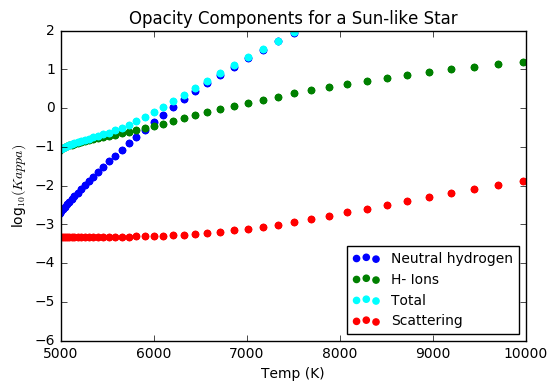

In [288]:
#For some reason, when I use plt.plot, it creates a line connecting the end points
plt.scatter(temp, np.log10(kappa_atomic), color = 'blue', label = 'Neutral hydrogen')
plt.scatter(temp, np.log10(kappa_ion), color = 'green', label = 'H- Ions')
plt.scatter(temp, kappa_total, color = 'cyan', label = 'Total')
plt.scatter(temp, sigma_total, color = 'red', label = 'Scattering')
plt.xlim(5000, 10000)
plt.ylim(-6, 2)
plt.legend(loc=4, prop={'size':10})
plt.xlabel('Temp (K)')
plt.ylabel(r'log$_{10}(Kappa)$')
plt.title('Opacity Components for a Sun-like Star')

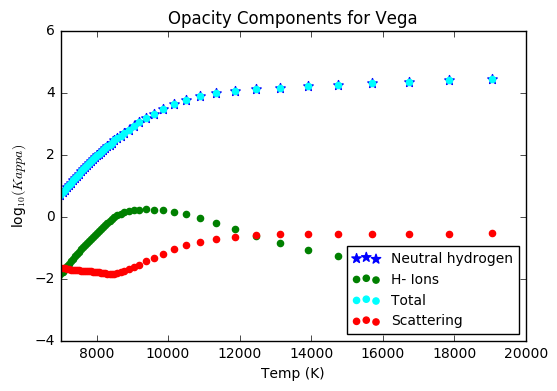

In [289]:
#For some reason, when I use plt.plot, it creates a line connecting the end points
plt.scatter(temp_vega, np.log10(kappa_atomic_vega), color = 'blue',marker = '*', s=50, label = 'Neutral hydrogen')
plt.scatter(temp_vega, np.log10(kappa_ion_vega), color = 'green', label = 'H- Ions')
plt.scatter(temp_vega, kappa_total_vega, color = 'cyan', label = 'Total')
plt.scatter(temp_vega, sigma_total_vega, color = 'red', label = 'Scattering')
plt.xlim(7000, 20000)
plt.ylim(-4, 6)
plt.legend(loc=4, prop={'size':10})
plt.xlabel('Temp (K)')
plt.ylabel(r'log$_{10}(Kappa)$')
plt.title('Opacity Components for Vega')